In [1]:
import cv2 as cv
import numpy as np
import math
import matplotlib.pyplot as plt

Sigma range used: 2.0 to 8.0 ( 24 scales )
Detections kept after NMS: 48


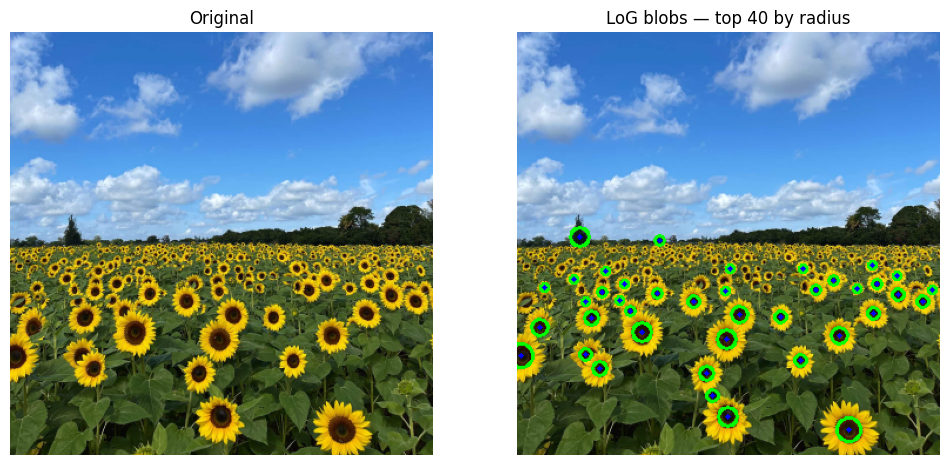


Largest circles (top 10 by radius):
idx: (x, y), radius_px, sigma, score
 1: (282, 338), r=10.21px, σ≈7.22, score=2.2223
 2: (3, 275), r=9.84px, σ≈6.96, score=1.7954
 3: (106, 255), r=8.36px, σ≈5.91, score=2.3286
 4: (179, 327), r=8.36px, σ≈5.91, score=2.1953
 5: (178, 261), r=7.99px, σ≈5.65, score=2.2532
 6: (53, 174), r=7.62px, σ≈5.39, score=1.8832
 7: (189, 240), r=6.52px, σ≈4.61, score=2.3100
 8: (274, 258), r=6.52px, σ≈4.61, score=2.2192
 9: (19, 251), r=6.52px, σ≈4.61, score=1.8478
10: (161, 290), r=6.15px, σ≈4.35, score=2.3247

Summary:
 - σ range: [2.00, 8.00] over 24 scales
 - Threshold (quantile): 1.660131
 - Detections before NMS: 51; after NMS: 48


In [2]:
img_path = 'the_berry_farms_sunflower_field.jpeg'
im = cv.imread(img_path, cv.IMREAD_REDUCED_COLOR_4)
g = cv.cvtColor(im, cv.COLOR_BGR2GRAY).astype(np.float32) / 255.0
H, W = g.shape

sigmas = np.linspace(2, 8, 24).astype(np.float32)
print("Sigma range used:", float(sigmas.min()), "to", float(sigmas.max()), "(", len(sigmas), "scales )")

R = np.zeros((H, W, len(sigmas)), dtype=np.float32)
for i, s in enumerate(sigmas):
    hw = int(math.ceil(3*s))
    y, x = np.mgrid[-hw:hw+1, -hw:hw+1]
    rr = x*x + y*y
    s2 = s*s
    k = (rr - 2*s2) * np.exp(-rr/(2*s2)) / (s**6)
    k = (k - k.mean()).astype(np.float32)
    resp = cv.filter2D(g, cv.CV_32F, k, borderType=cv.BORDER_REPLICATE)
    R[..., i] = (s*s) * resp

thr = np.quantile(R, 0.998)
cands = []
ker = np.ones((3,3), np.uint8)
for i in range(len(sigmas)):
    M = cv.dilate(R[..., i], ker)
    m = (R[..., i] == M) & (R[..., i] >= thr)
    if i > 0: m &= R[..., i] >= R[..., i-1]
    if i < len(sigmas)-1: m &= R[..., i] >= R[..., i+1]
    ys, xs = np.where(m)
    for y0, x0 in zip(ys, xs):
        cands.append((float(R[y0, x0, i]), int(x0), int(y0), float(sigmas[i])))

cands.sort(reverse=True, key=lambda t: t[0])

used = np.zeros(len(cands), dtype=bool)
final = []
for i in range(len(cands)):
    if used[i]: continue
    a = cands[i]
    used[i] = True
    for j in range(i+1, len(cands)):
        if used[j]: continue
        b = cands[j]
        ra = math.sqrt(2)*a[3]; rb = math.sqrt(2)*b[3]
        d2 = (a[1]-b[1])**2 + (a[2]-b[2])**2
        if d2 <= (0.5*(ra+rb))**2:
            used[j] = True
    final.append(a)

print(f"Detections kept after NMS: {len(final)}")

with_r = [(s, x, y, math.sqrt(2)*sg) for (s, x, y, sg) in final]
with_r.sort(key=lambda t: t[3], reverse=True)

K = min(40, len(with_r))
out = im.copy()
for i in range(K):
    sc, x, y, r = with_r[i]
    cv.circle(out, (x, y), int(round(r)), (0,255,0), 2)
    cv.circle(out, (x, y), 2, (255,0,0), -1)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1); plt.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB)); plt.title("Original"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(cv.cvtColor(out, cv.COLOR_BGR2RGB)); plt.title(f"LoG blobs — top {K} by radius"); plt.axis('off')
plt.show()

L = min(10, len(with_r))
print("\nLargest circles (top {} by radius):".format(L))
print("idx: (x, y), radius_px, sigma, score")
for i in range(L):
    sc, x, y, r = with_r[i]
    print(f"{i+1:2d}: ({x}, {y}), r={r:.2f}px, σ≈{(r/math.sqrt(2)):.2f}, score={sc:.4f}")

print("\nSummary:")
print(f" - σ range: [{float(sigmas.min()):.2f}, {float(sigmas.max()):.2f}] over {len(sigmas)} scales")
print(f" - Threshold (quantile): {thr:.6f}")
print(f" - Detections before NMS: {len(cands)}; after NMS: {len(final)}")


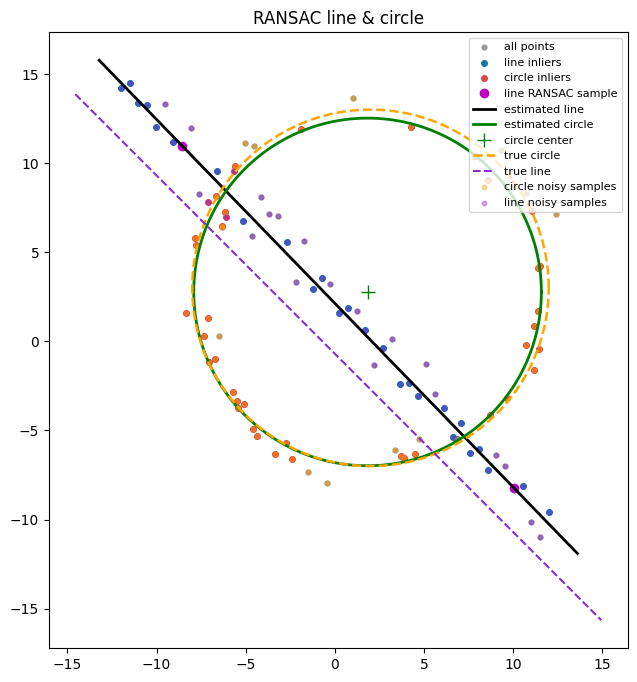

LINE: a x + b y = d
a=-0.7179, b=-0.6961, d=-1.4861, ||n||=1.0000, inliers=29/100

CIRCLE:
center=(1.8370, 2.7702), r=9.7518, inliers=40/71


In [3]:
np.random.seed(0)
N=100;r=10.0;x0,y0=2.0,3.0;s=r/16.0
t=np.random.uniform(0,2*np.pi,N//2); n=s*np.random.randn(N//2)
xc=x0+(r+n)*np.cos(t); yc=y0+(r+n)*np.sin(t)
m,b=-1.0,2.0; sl=1.0
xl=np.linspace(-12,12,N//2); yl=m*xl+b+sl*np.random.randn(N//2)
X=np.vstack([np.c_[xc,yc],np.c_[xl,yl]])

bestL=None; itL=1000; thrL=0.5; minL=25
for _ in range(itL):
    i,j=np.random.choice(len(X),2,replace=False)
    p,q=X[i],X[j]; v=q-p
    if np.allclose(v,0): continue
    nrm=np.array([-v[1],v[0]],float); nn=np.linalg.norm(nrm)
    if nn==0: continue
    nrm/=nn; d=float(nrm@p)
    ds=np.abs(X@nrm-d); inl=ds<=thrL; c=int(inl.sum())
    if c<minL: continue
    P=X[inl]; mu=P.mean(0); U,S,Vt=np.linalg.svd(P-mu,full_matrices=False)
    dir=Vt[0]; nor=np.array([-dir[1],dir[0]],float); nor/=np.linalg.norm(nor)
    d2=float(nor@mu)
    if (bestL is None) or (c>bestL[0]): bestL=(c,nor[0],nor[1],d2,inl,(p,q))

inlL=bestL[4]; Xr=X[~inlL]
def c3(a,b,c,eps=1e-9):
    x1,y1=a; x2,y2=b; x3,y3=c
    A=x2-x1; B=y2-y1; C=x3-x1; D=y3-y1
    E=A*(x1+x2)+B*(y1+y2); F=C*(x1+x3)+D*(y1+y3); G=2*(A*(y3-y2)-B*(x3-x2))
    if abs(G)<eps: return None
    cx=(D*E-B*F)/G; cy=(A*F-C*E)/G; R=np.hypot(cx-x1,cy-y1); return cx,cy,R

bestC=None; itC=2500; thrC=0.7; minC=20; M=len(Xr)
for _ in range(itC):
    if M<3: break
    idx=np.random.choice(M,3,replace=False)
    v=c3(*Xr[idx]); 
    if v is None: continue
    cx,cy,R=v; d=np.hypot(Xr[:,0]-cx,Xr[:,1]-cy); inl=np.abs(d-R)<=thrC; c=int(inl.sum())
    if c<minC: continue
    P=Xr[inl]; x,y=P[:,0],P[:,1]
    A=np.c_[x,y,np.ones_like(x)]; bb=-(x*x+y*y); sol,_res,_r,_s=np.linalg.lstsq(A,bb,rcond=None)
    cx2,cy2=-sol[0]/2,-sol[1]/2; R2=np.sqrt(cx2*cx2+cy2*cy2-sol[2])
    if np.isfinite(R2) and ((bestC is None) or (c>bestC[0])): bestC=(c,cx2,cy2,R2,inl,Xr[idx])

a,b,d=bestL[1],bestL[2],bestL[3]
linl=X[inlL]; cinl=Xr[bestC[4]]; cx,cy,R=bestC[1],bestC[2],bestC[3]

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X[:, 0], X[:, 1], s=12, c="#999", label="all points")
ax.scatter(linl[:, 0], linl[:, 1], s=16, c="#17a", label="line inliers")
ax.scatter(cinl[:, 0], cinl[:, 1], s=16, c="#d44", label="circle inliers")
p, q = bestL[5]
ax.plot([p[0], q[0]], [p[1], q[1]], "mo", ms=6, label="line RANSAC sample")
xx = np.array(ax.get_xlim())
if abs(b) > 1e-9:
    ax.plot(xx, (d - a * xx) / b, "k-", lw=2, label="estimated line")
else:
    xv = d / a
    ax.plot([xv, xv], ax.get_ylim(), "k-", lw=2, label="estimated line")
th = np.linspace(0, 2 * np.pi, 400)
ax.plot(cx + R * np.cos(th), cy + R * np.sin(th), "g-", lw=2, label="estimated circle")
ax.plot(cx, cy, "g+", ms=10, label="circle center")
ax.plot(x0 + r * np.cos(th), y0 + r * np.sin(th), "--", color="#ffa500", linewidth=1.8, label="true circle")
xx_gt = np.linspace(*ax.get_xlim(), 200)
ax.plot(xx_gt, m * xx_gt + b, "--", color="#8a2be2", linewidth=1.5, label="true line")
ax.scatter(xc, yc, s=10, c="#ffa500", alpha=0.4, label="circle noisy samples")
ax.scatter(xl, yl, s=10, c="#8a2be2", alpha=0.4, label="line noisy samples")
ax.set_aspect("equal", "box")
ax.set_title("RANSAC line & circle")
ax.legend(loc="upper right", fontsize=8)
plt.show()

print("LINE: a x + b y = d")
print(f"a={a:.4f}, b={b:.4f}, d={d:.4f}, ||n||={np.linalg.norm([a,b]):.4f}, inliers={linl.shape[0]}/{X.shape[0]}")
print("\nCIRCLE:")
print(f"center=({cx:.4f}, {cy:.4f}), r={R:.4f}, inliers={cinl.shape[0]}/{Xr.shape[0]}")


In [8]:
import cv2 as cv, numpy as np
import matplotlib.pyplot as plt

# --- paths (edit these) ---
main_path = "images/boarrd.jpg"     # architectural image
flag_path = "images/banner.jpg"     # flag/logo (PNG with alpha if possible)

# ...existing code...
# --- click 4 destination points on the plane (clockwise TL->TR->BR->BL) ---
assert M is not None, "Main image not loaded. Check path/filename (note: your code uses 'boarrd.jpg')."
click_img = M.copy()
pts = []
def on_mouse(event, x, y, flags, param):
    if event == cv.EVENT_LBUTTONDOWN and len(pts) < 4:
        pts.append((x, y))
        cv.circle(click_img, (x, y), 5, (0, 0, 255), -1)
        cv.imshow("Click 4 points: TL->TR->BR->BL (ESC to cancel)", click_img)

cv.namedWindow("Click 4 points: TL->TR->BR->BL (ESC to cancel)", cv.WINDOW_AUTOSIZE)
cv.imshow("Click 4 points: TL->TR->BR->BL (ESC to cancel)", click_img)
cv.setMouseCallback("Click 4 points: TL->TR->BR->BL (ESC to cancel)", on_mouse)

# wait for 4 clicks
while len(pts) < 4:
    if cv.waitKey(20) & 0xFF == 27:  # ESC to abort
        break
cv.destroyAllWindows()
dst_raw = np.array(pts, dtype=np.float32)
# ...existing code...

# wait for 4 clicks
while len(pts) < 4:
    if cv.waitKey(20) & 0xFF == 27:  # ESC to abort
        break
cv.destroyAllWindows()
dst_raw = np.array(pts, dtype=np.float32)

# --- order clicked points robustly as TL,TR,BR,BL (no functions) ---
c = dst_raw.mean(axis=0)
ang = np.arctan2(dst_raw[:,1]-c[1], dst_raw[:,0]-c[0])
dst_ = dst_raw[np.argsort(ang)]
s = dst_.sum(1); d = np.diff(dst_, axis=1).ravel()
tl = dst_[np.argmin(s)]; br = dst_[np.argmax(s)]
tr = dst_[np.argmin(d)]; bl = dst_[np.argmax(d)]
dst = np.array([tl,tr,br,bl], dtype=np.float32)

# --- source corners = full flag image ---
hF, wF = F.shape[:2]
src = np.array([[0,0],[wF,0],[wF,hF],[0,hF]], dtype=np.float32)

# --- homography and warp ---
H, _ = cv.findHomography(src, dst, method=cv.RANSAC, ransacReprojThreshold=3.0)
warped = cv.warpPerspective(F, H, (M.shape[1], M.shape[0]))

# --- build a soft mask on the quad ---
mask = np.zeros(M.shape[:2], np.uint8)
cv.fillConvexPoly(mask, dst.astype(np.int32), 255)
soft = cv.GaussianBlur(mask, (0,0), 7)        # feather edges
A = (soft.astype(np.float32)/255.0)[...,None] # HxWx1 in [0,1]

# --- get RGB flag (keep if 4ch) ---
if warped.ndim==3 and warped.shape[2]==4:
    F_rgb = warped[...,:3].astype(np.float32)
else:
    F_rgb = warped.astype(np.float32)


# --- MULTIPLY blend (preserve wall texture/shading) ---
M32 = M.astype(np.float32)
F_norm = F_rgb/255.0
out_mul = M32*(1.0 - A) + (M32*(F_norm)) * A
out_mul = np.clip(out_mul, 0, 255).astype(np.uint8)
out = out_mul        


# --- quick visualization of clicked quad + result ---
vis = M.copy()
for i in range(4):
    p1 = tuple(map(int, dst[i])); p2 = tuple(map(int, dst[(i+1)%4]))
    cv.line(vis, p1, p2, (0,255,0), 2)
    cv.circle(vis, p1, 5, (0,0,255), -1)

# --- save & print H ---
cv.imwrite("q3_clicked_quad.png", vis)
cv.imwrite("q3_multiply_result.png", out)
print("Saved: q3_overlay_result.png")
print("Homography H:\n", H)


Saved: q3_overlay_result.png
Homography H:
 [[ 3.36873207e-01 -1.36274993e-02  7.70000000e+01]
 [ 6.23489056e-02  2.23887320e-01  7.30000000e+01]
 [ 1.23145118e-04 -5.57896729e-05  1.00000000e+00]]


Keypoints: img1=2674, img5=3923 | matches=97


C:\Users\User\AppData\Local\Temp\ipykernel_8488\1965290367.py:69: RuntimeWarning: divide by zero encountered in divide
  w = w[:, :2] / w[:, 2:3]
C:\Users\User\AppData\Local\Temp\ipykernel_8488\1965290367.py:69: RuntimeWarning: invalid value encountered in divide
  w = w[:, :2] / w[:, 2:3]


RANSAC inliers: 6 / 97
RMSE (ours, all matches): 266.686px
RMSE (given, all matches): 312.611px


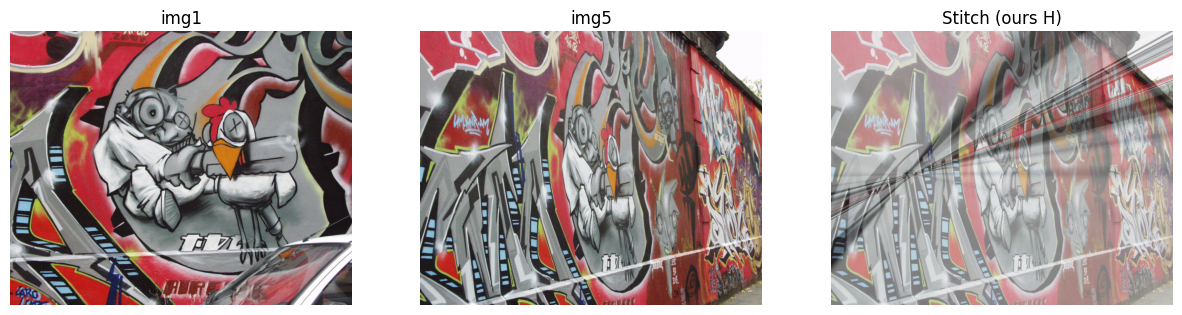

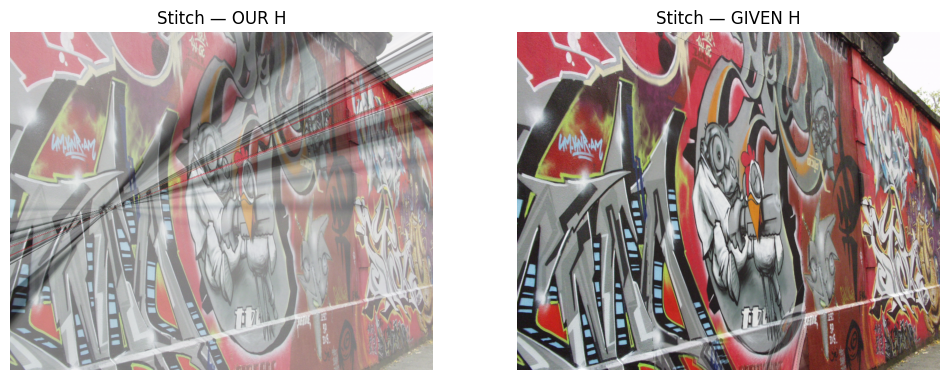

In [7]:
import cv2 as cv, numpy as np, matplotlib.pyplot as plt, os, glob

# --- load images ---
i1 = cv.imread("graf/img1.ppm", cv.IMREAD_COLOR)
i5 = cv.imread("graf/img5.ppm", cv.IMREAD_COLOR)
assert i1 is not None and i5 is not None, "Check graf/img1.ppm and graf/img5.ppm paths."

# --- SIFT (require opencv-contrib); fallback: AKAZE ---
use_float = True
try:
    sift = cv.SIFT_create()
    kp1, des1 = sift.detectAndCompute(i1, None)
    kp5, des5 = sift.detectAndCompute(i5, None)
    matcher = cv.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=64))
except Exception as _:
    print("[Note] SIFT not available → falling back to AKAZE + Hamming.")
    akaze = cv.AKAZE_create()
    kp1, des1 = akaze.detectAndCompute(i1, None)
    kp5, des5 = akaze.detectAndCompute(i5, None)
    matcher = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=False)
    use_float = False

# --- Lowe ratio matches ---
raw = matcher.knnMatch(des1, des5, k=2)
good = []
for m,n in raw:
    if m.distance < 0.75 * n.distance:
        good.append(m)

pts1 = np.float32([kp1[m.queryIdx].pt for m in good])
pts5 = np.float32([kp5[m.trainIdx].pt for m in good])
print(f"Keypoints: img1={len(kp1)}, img5={len(kp5)} | matches={len(good)}")

# ========== RANSAC (own code) with normalized DLT ==========
rng = np.random.default_rng(0)
iters = 2500
thr = 3.0  # reprojection px
best = None

def norm2D(P):
    c = P.mean(0)
    d = np.mean(np.linalg.norm(P - c, axis=1))
    s = np.sqrt(2) / (d + 1e-9)
    T = np.array([[s,0,-s*c[0]],[0,s,-s*c[1]],[0,0,1]], dtype=np.float64)
    Ph = np.hstack([P, np.ones((P.shape[0],1))])
    Pn = (T @ Ph.T).T[:, :2]
    return Pn, T

def H_from_4(p, q):
    # p->q, both Nx2, DLT on normalized points
    pn, Tp = norm2D(p); qn, Tq = norm2D(q)
    A = []
    for (x,y),(u,v) in zip(pn, qn):
        A.append([0,0,0, -x,-y,-1,  v*x, v*y, v])
        A.append([x,y,1,  0, 0, 0, -u*x,-u*y,-u])
    A = np.asarray(A, dtype=np.float64)
    _,_,Vt = np.linalg.svd(A)
    Hn = Vt[-1].reshape(3,3)
    H = np.linalg.inv(Tq) @ Hn @ Tp
    return H / H[2,2]

for _ in range(iters):
    if len(pts1) < 4: break
    idx = rng.choice(len(pts1), 4, replace=False)
    H = H_from_4(pts1[idx], pts5[idx])
    # reprojection error img1->img5
    P1h = np.hstack([pts1, np.ones((len(pts1),1))])
    w = (H @ P1h.T).T
    w = w[:, :2] / w[:, 2:3]
    e = np.linalg.norm(w - pts5, axis=1)
    inl = e <= thr
    c = int(inl.sum())
    if best is None or c > best["count"]:
        best = {"H": H, "inl": inl, "count": c}

print(f"RANSAC inliers: {best['count']} / {len(pts1)}")

# --- refine H with all inliers (final DLT) ---
in1 = pts1[best["inl"]]; in5 = pts5[best["inl"]]
H_ours = H_from_4(in1, in5)

# --- try to load the given homography (if present) ---
H_given = None
cands = ["graf/H1to5p.txt", "graf/H1to5p", "graf/H1to5p_matlab.txt"]
for f in cands:
    if os.path.exists(f):
        try:
            Hg = np.loadtxt(f)
            if Hg.size == 9:
                H_given = Hg.reshape(3,3)
                break
        except:
            pass

# --- compare reprojection RMSE (ours vs given) ---
def repro_rmse(H, Psrc, Pdst):
    P1h = np.hstack([Psrc, np.ones((len(Psrc),1))])
    w = (H @ P1h.T).T
    w = w[:, :2] / w[:, 2:3]
    return float(np.sqrt(np.mean(np.sum((w - Pdst)**2, axis=1))))

rmse_all_ours = repro_rmse(H_ours, pts1, pts5)
print(f"RMSE (ours, all matches): {rmse_all_ours:.3f}px")
if H_given is not None:
    rmse_all_given = repro_rmse(H_given, pts1, pts5)
    print(f"RMSE (given, all matches): {rmse_all_given:.3f}px")
else:
    print("[Info] Given homography file not found; skip comparison.")

# warp img1 corners by H_ours to get panorama bounds
h1,w1 = i1.shape[:2]
h5,w5 = i5.shape[:2]
c1 = np.array([[0,0],[w1,0],[w1,h1],[0,h1]], np.float32)
c1h = np.hstack([c1, np.ones((4,1))])
wc = (H_ours @ c1h.T).T
wc = wc[:, :2] / wc[:, 2:3]

all_pts = np.vstack([wc, np.array([[0,0],[w5,0],[w5,h5],[0,h5]], np.float32)])
xmin,ymin = np.floor(all_pts.min(0)).astype(int)
xmax,ymax = np.ceil(all_pts.max(0)).astype(int)

tx, ty = -min(0, xmin), -min(0, ymin)
Tw = np.array([[1,0,tx],[0,1,ty],[0,0,1]], dtype=np.float64)
W = (xmax - min(0, xmin), ymax - min(0, ymin))  # (width, height)

# warp img1 → panorama
pan1 = cv.warpPerspective(i1, Tw @ H_ours, (W[0], W[1]))

# paste img5 into panorama
pan = pan1.copy()
pan[ty:ty+h5, tx:tx+w5] = i5

# simple feather blend on overlap
mask1 = (pan1.sum(axis=2) > 0).astype(np.uint8)
mask2 = np.zeros_like(mask1)
mask2[ty:ty+h5, tx:tx+w5] = 1
over = (mask1 & mask2).astype(np.uint8)

# blend: average where overlap, keep where single
out = pan.copy()
ov_idx = np.where(over==1)
out[ov_idx] = ((pan1[ov_idx].astype(np.float32) + i5[(ov_idx[0]-ty, ov_idx[1]-tx)].astype(np.float32))/2).astype(np.uint8)

# --- show ---
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(cv.cvtColor(i1, cv.COLOR_BGR2RGB)); plt.title("img1"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(cv.cvtColor(i5, cv.COLOR_BGR2RGB)); plt.title("img5"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(cv.cvtColor(out, cv.COLOR_BGR2RGB)); plt.title("Stitch (ours H)"); plt.axis('off')
plt.show()

# Optionally, also visualize with given H if available

pan1g = cv.warpPerspective(i1, Tw @ H_given, (W[0], W[1]))
outg = pan1g.copy()
outg[ty:ty+h5, tx:tx+w5] = i5
ov = ((pan1g.sum(2)>0)&(mask2==1))
oi = np.where(ov)
outg[oi] = ((pan1g[oi].astype(np.float32)+i5[(oi[0]-ty, oi[1]-tx)].astype(np.float32))/2).astype(np.uint8)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(cv.cvtColor(out, cv.COLOR_BGR2RGB)); plt.title("Stitch — OUR H"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(cv.cvtColor(outg, cv.COLOR_BGR2RGB)); plt.title("Stitch — GIVEN H"); plt.axis('off')
plt.show()
